In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from scipy.stats import randint, uniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
from tqdm.auto import tqdm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import label_binarize

In [65]:
# Read cleaned data from csv
df = pd.read_csv('input/movie_data_tmbd_cleaned.csv', sep='|')

In [66]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17426 entries, 0 to 17425
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  17426 non-null  bool   
 1   backdrop_path          16267 non-null  object 
 2   belongs_to_collection  3369 non-null   object 
 3   budget                 17426 non-null  int64  
 4   genres                 17426 non-null  object 
 5   homepage               4959 non-null   object 
 6   id                     17426 non-null  float64
 7   imdb_id                17420 non-null  object 
 8   original_language      17426 non-null  object 
 9   original_title         17426 non-null  object 
 10  overview               17365 non-null  object 
 11  popularity             17426 non-null  float64
 12  poster_path            17426 non-null  object 
 13  production_companies   17426 non-null  object 
 14  production_countries   17426 non-null  object 
 15  re

# Scoring prediction

In [67]:
# Take only the columns we need
df = df[['original_title', 'original_language', 'release_date', 'popularity', 'vote_count', 'genres', 'overview', 'budget', 'revenue', 'spoken_languages', 'runtime', 'vote_average']]
print(df.head())

         original_title original_language release_date  popularity  \
0  Lonely Are the Brave                en   1962-05-24       8.262   
1  Vérités et Mensonges                fr   1975-03-12       7.830   
2    Il colosso di Rodi                it   1961-06-15       9.668   
3                Victim                en   1961-08-01       5.896   
4     Sergeant Rutledge                en   1960-05-18       6.003   

   vote_count                                             genres  \
0        70.0  [{'id': 18, 'name': 'Drama'}, {'id': 37, 'name...   
1       178.0                [{'id': 99, 'name': 'Documentary'}]   
2        94.0                    [{'id': 36, 'name': 'History'}]   
3        57.0                      [{'id': 18, 'name': 'Drama'}]   
4        59.0                    [{'id': 37, 'name': 'Western'}]   

                                            overview  budget  revenue  \
0  A fiercely independent cowboy arranges to have...       0        0   
1  Documents the lives o

Axes(0.125,0.11;0.775x0.77)


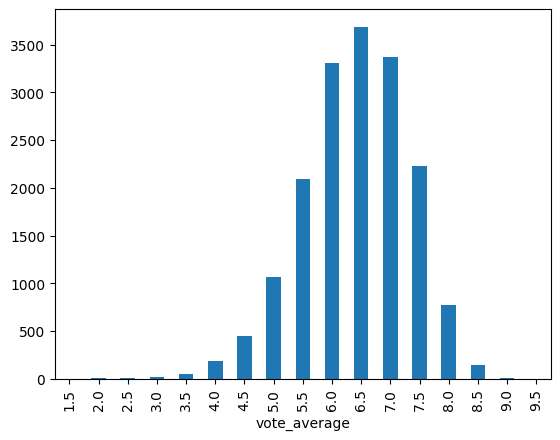

In [68]:
# Map 'vote_average' to nearest 0.5
df['vote_average'] = ((df['vote_average'] * 2).round() / 2)
print(df['vote_average'].value_counts().sort_index().plot(kind='bar'))

In [69]:
#Group vote_average into categories:
# 0.0-5.0 -> bad
# 5.5-6.0 -> mediocre
# 6.5-7.0 -> good
# 7.5-9.9 -> great

# Define the bins and labels
bins = [0.0, 5.0, 6.0, 7.0, 9.9]
labels = ['bad', 'mediocre', 'good', 'great']

# Group vote_average into categories
df['category'] = pd.cut(df['vote_average'], bins=bins, labels=labels, right=True)

# Display the DataFrame
print(df['category'].value_counts())

category
good        7064
mediocre    5407
great       3161
bad         1794
Name: count, dtype: int64


In [70]:
# For now drop non-numerical columns
df = df.drop(columns=['original_title', 'original_language', 'release_date', 'genres', 'overview', 'spoken_languages'])

In [71]:
print(df.info())
print("Duplicates: " + str(df.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17426 entries, 0 to 17425
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   popularity    17426 non-null  float64 
 1   vote_count    17426 non-null  float64 
 2   budget        17426 non-null  int64   
 3   revenue       17426 non-null  int64   
 4   runtime       17426 non-null  float64 
 5   vote_average  17426 non-null  float64 
 6   category      17426 non-null  category
dtypes: category(1), float64(4), int64(2)
memory usage: 834.2 KB
None
Duplicates: 1


In [72]:
X = df.drop(columns=['vote_average', 'category'])
Y = df['category']


In [73]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Training set size: ", len(X_train))
print("Test set size: ", len(X_test))

Training set size:  13940
Test set size:  3486


# Opaque models

## SVM

In [74]:
# clf = make_pipeline(StandardScaler(), svm.SVC(gamma='auto'))
clf = svm.SVC(gamma='auto')
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.39615605278255883


In [75]:
print(sorted(Y_test.unique()))

['bad', 'good', 'great', 'mediocre']


In [76]:
print(Y_test.value_counts())

category
good        1398
mediocre    1098
great        642
bad          348
Name: count, dtype: int64


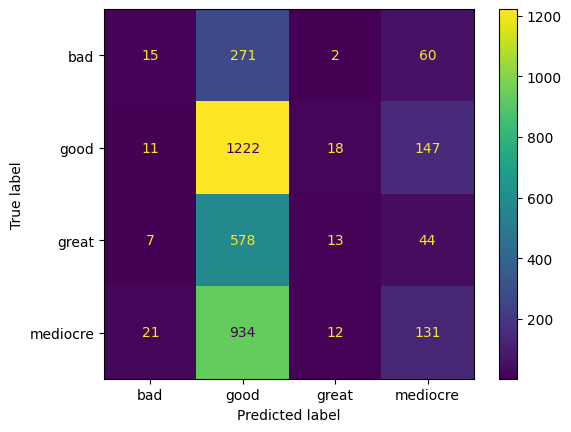

In [78]:
# Print confusion matrix for the model
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(Y_test.unique()))
disp.plot()